# Load Libraries

In [1]:
#Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns

from sklearn import linear_model, ensemble
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, f1_score, make_scorer

import pickle

# Initial Exploration

In [2]:
# Import Data
videogames = pd.read_csv('../data/vgsales.csv')

In [3]:
# Inspect Data
videogames.head()

Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37

In [4]:
# Inspect Data
videogames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [44]:
videogames.describe()

Rank          Year      NA_Sales      EU_Sales      JP_Sales  \
count  16340.000000  16340.000000  16340.000000  16340.000000  16340.000000   
mean    8290.304100   2006.402081    265.718482    147.752754     78.616891   
std     4793.233778      5.824936    821.942219    508.916126    311.443135   
min        1.000000   1980.000000      0.000000      0.000000      0.000000   
25%     4133.750000   2003.000000      0.000000      0.000000      0.000000   
50%     8291.500000   2007.000000     80.000000     20.000000      0.000000   
75%    12440.250000   2010.000000    240.000000    110.000000     40.000000   
max    16600.000000   2016.000000  41490.000000  29020.000000  10220.000000   

        Other_Sales  Global_Sales  publisher_title_count     globalpop  \
count  16340.000000  16340.000000           16340.000000  16340.000000   
mean      48.418605    540.781518             497.728886   6663.289918   
std      189.941499   1565.852531             426.450433    478.734453   
min        0.000000     10.000000               1.000000   4458.003466   
25%        0.000000     60.000000              73.000000   6381.185141   
50%       10.000000    170.000000             376.000000   6705.946643   
75%       40.000000    480.000000             917.000000   6956.823588   
max    10570.000000  82740.000000            1343.000000   7464.021934   

       global_sales_as_pct_of_pop  pub_avg_prior_sales  log_Global_Sales  
count                16340.000000         16340.000000      16340.000000  
mean                     0.008315           587.373913          5.171228  
std                      0.024765           641.511523          1.463024  
min                      0.000134             0.000000          2.302585  
25%                      0.000917           221.764706          4.094345  
50%                      0.002587           437.781403          5.135798  
75%                      0.007247           741.284047          6.173786  
max                      1.249185          5120.000000         11.323458

## Missing Value Handling and Feature Engineering

In [6]:
# The platforms category is extremely granular and unlikely to be useful for modeling
# Here I use a dictionary to create additional columns.
# platformcat = separated out into the five major groups (nintendo, playstation, xbox, pc, and other)
# platformtype = separated out into the three major groups (console, portable, PC)

platformcatsdict = {
    'DS' : ['Nintendo', 'Portable'],
    'PS2' : ['PlayStation', 'Console'],
    'PS3' : ['PlayStation', 'Console'],
    'Wii' : ['Nintendo', 'Console'],
    'X360' : ['Xbox', 'Console'],
    'PSP' : ['PlayStation', 'Portable'],
    'PS' : ['PlayStation', 'Console'],
    'PC' : ['PC', 'PC'],
    'XB' : ['Xbox', 'Console'],
    'GBA' : ['Nintendo', 'Portable'],
    'GC' : ['Nintendo', 'Console'],
    '3DS' : ['Nintendo', 'Portable'],
    'PSV' : ['PlayStation', 'Portable'],
    'PS4' : ['PlayStation', 'Console'],
    'N64' : ['Nintendo', 'Console'],
    'SNES' : ['Nintendo', 'Console'],
    'XOne' : ['Xbox', 'Console'],
    'SAT' : ['Other', 'Console'],
    'WiiU' : ['Nintendo', 'Console'],
    '2600' : ['Other', 'Console'],
    'GB' : ['Nintendo', 'Portable'],
    'NES' : ['Nintendo', 'Console'],
    'DC' : ['Other', 'Console'],
    'GEN' : ['Other', 'Console'],
    'NG' : ['Other', 'Console'],
    'WS' : ['Other', 'Portable'],
    'SCD' : ['Other', 'Console'],
    '3DO' : ['Other', 'Console'],
    'TG16' : ['Other', 'Console'],
    'GG' : ['Other', 'Console'],
    'PCFX' : ['Other', 'Console']
}

videogames['platformcat'] = [platformcatsdict[x][0] for x in videogames['Platform']]
videogames['platformcat'].value_counts()

videogames['platformtype'] = [platformcatsdict[x][1] for x in videogames['Platform']]
videogames['platformcat'].value_counts(), videogames['platformtype'].value_counts()

# We will decide whether to include these new features during EDA

(PlayStation    6648
 Nintendo       6272
 Xbox           2302
 PC              960
 Other           416
 Name: platformcat, dtype: int64,
 Console     10414
 Portable     5224
 PC            960
 Name: platformtype, dtype: int64)

In [7]:
# Change the data type of 'Year' column to int
videogames['Year'] = videogames['Year'].astype('int', errors = 'ignore')

In [8]:
# These games seem to have erroneous release dates, or are in a release year that isn't a part of the main dataset.
# Including them may impact our models, so they will be removed. 
videogames.drop(videogames[videogames['Year'].isin([2017, 2020])].index, inplace = True)

In [9]:
# Take a look at which video games are missing the year indicator.
# Some of these are sports games that have a year in their title. We can fix these. 
# For example, any sports game that has 2005 in the title is almost always released in 2004

videogames[videogames['Year'].isna() == True]

Rank                         Name Platform  Year         Genre  \
179      180              Madden NFL 2004      PS2   NaN        Sports   
377      378             FIFA Soccer 2004      PS2   NaN        Sports   
431      432   LEGO Batman: The Videogame      Wii   NaN        Action   
470      471   wwe Smackdown vs. Raw 2006      PS2   NaN      Fighting   
607      608               Space Invaders     2600   NaN       Shooter   
...      ...                          ...      ...   ...           ...   
16307  16310                Freaky Flyers       GC   NaN        Racing   
16327  16330                    Inversion       PC   NaN       Shooter   
16366  16369  Hakuouki: Shinsengumi Kitan      PS3   NaN     Adventure   
16427  16430                 Virtua Quest       GC   NaN  Role-Playing   
16493  16496                   The Smurfs      3DS   NaN        Action   

                                    Publisher  NA_Sales  EU_Sales  JP_Sales  \
179                           Electronic Arts      4.26      0.26      0.01   
377                           Electronic Arts      0.59      2.36      0.04   
431    Warner Bros. Interactive Entertainment      1.86      1.02      0.00   
470                                       NaN      1.57      1.02      0.00   
607                                     Atari      2.36      0.14      0.00   
...                                       ...       ...       ...       ...   
16307                                 Unknown      0.01      0.00      0.00   
16327                      Namco Bandai Games      0.01      0.00      0.00   
16366                                 Unknown      0.01      0.00      0.00   
16427                                 Unknown      0.01      0.00      0.00   
16493                                 Unknown      0.00      0.01      0.00   

       Other_Sales  Global_Sales  platformcat platformtype  
179           0.71          5.23  PlayStation      Console  
377           0.51          3.49  PlayStation      Console  
431           0.29          3.17     Nintendo      Console  
470           0.41          3.00  PlayStation      Console  
607           0.03          2.53        Other      Console  
...            ...           ...          ...          ...  
16307         0.00          0.01     Nintendo      Console  
16327         0.00          0.01           PC           PC  
16366         0.00          0.01  PlayStation      Console  
16427         0.00          0.01     Nintendo      Console  
16493         0.00          0.01     Nintendo     Portable  

[271 rows x 13 columns]

In [10]:
# Define regular expression to find video games with years in their name
# Selects a group of characters that begins with 19 or 20 and is followed by two other numbers
expression = '(19|20\d{2})'

# Use rank as a unique identifier and create a list of the records that will be changed so that I can check if the transformation works
checklist = list(videogames.loc[(videogames['Name'].str.contains(expression) & videogames['Year'].isna() == True), ['Name', 'Year', 'Rank']]['Rank'].values)

C:\Users\atyou\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [11]:
# Extract series to replace missing years
replacement_years = videogames[(videogames['Name'].str.contains(expression) & videogames['Year'].isna() == True)]['Name'].str.extract(expression).astype('int')
replacement_years = replacement_years - 1
replacement_years = replacement_years.values
replacement_years = replacement_years.reshape(-1,)

C:\Users\atyou\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [12]:
# Reassign missing years to the new replacement_years list
videogames.loc[(videogames['Name'].str.contains(expression) & videogames['Year'].isna() == True), 'Year'] = replacement_years

C:\Users\atyou\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [13]:
# Verify that the years were changed successfully
videogames[videogames['Rank'].isin(checklist)]

Rank                               Name Platform    Year     Genre  \
179      180                    Madden NFL 2004      PS2  2003.0    Sports   
377      378                   FIFA Soccer 2004      PS2  2003.0    Sports   
470      471         wwe Smackdown vs. Raw 2006      PS2  2005.0  Fighting   
1649    1651                NASCAR Thunder 2003      PS2  2002.0    Racing   
2586    2588     PES 2009: Pro Evolution Soccer      PSP  2008.0    Sports   
3501    3503                    Madden NFL 2002       XB  2001.0    Sports   
4797    4799                   NFL GameDay 2003      PS2  2002.0    Sports   
5162    5164                      NBA Live 2003       XB  2002.0    Sports   
5240    5242                 Tomb Raider (2013)       PC  2012.0    Action   
5669    5671             All-Star Baseball 2005      PS2  2004.0    Sports   
5901    5903                      NBA Live 2003       GC  2002.0    Sports   
8929    8931             All-Star Baseball 2005       XB  2004.0    Sports   
12922  12924                Tour de France 2011     X360  2010.0    Racing   
13870  13872                    Sega Rally 2006      PS2  2005.0    Racing   
15739  15742              Football Manager 2007     X360  2006.0    Sports   
15865  15868  PDC World Championship Darts 2008       DS  2007.0    Sports   
16057  16060  PDC World Championship Darts 2008      PSP  2007.0    Sports   

                          Publisher  NA_Sales  EU_Sales  JP_Sales  \
179                 Electronic Arts      4.26      0.26      0.01   
377                 Electronic Arts      0.59      2.36      0.04   
470                             NaN      1.57      1.02      0.00   
1649                        Unknown      0.60      0.46      0.00   
2586   Konami Digital Entertainment      0.04      0.33      0.26   
3501                        Unknown      0.53      0.02      0.00   
4797                        Unknown      0.20      0.15      0.00   
5162                Electronic Arts      0.31      0.04      0.00   
5240                    Square Enix      0.06      0.25      0.00   
5669                        Unknown      0.16      0.12      0.00   
5901                Electronic Arts      0.23      0.06      0.00   
8929                        Unknown      0.11      0.03      0.00   
12922        Focus Home Interactive      0.00      0.05      0.00   
13870                       Unknown      0.00      0.00      0.04   
15739                          Sega      0.00      0.01      0.00   
15865                       Unknown      0.01      0.00      0.00   
16057            Oxygen Interactive      0.01      0.00      0.00   

       Other_Sales  Global_Sales  platformcat platformtype  
179           0.71          5.23  PlayStation      Console  
377           0.51          3.49  PlayStation      Console  
470           0.41          3.00  PlayStation      Console  
1649          0.16          1.22  PlayStation      Console  
2586          0.17          0.80  PlayStation     Portable  
3501          0.03          0.58         Xbox      Console  
4797          0.05          0.40  PlayStation      Console  
5162          0.01          0.36         Xbox      Console  
5240          0.05          0.36           PC           PC  
5669          0.04          0.32  PlayStation      Console  
5901          0.01          0.30     Nintendo      Console  
8929          0.01          0.15         Xbox      Console  
12922         0.01          0.05         Xbox      Console  
13870         0.00          0.04  PlayStation      Console  
15739         0.00          0.02         Xbox      Console  
15865         0.00          0.02     Nintendo     Portable  
16057         0.00          0.01  PlayStation     Portable

In [14]:
# Remove all other rows that have a missing year
videogames.drop(videogames[videogames['Year'].isna() == True].index, inplace = True)

In [15]:
# The remaining missing values are in the Publisher column, lets take a look at them:
# They all appear to be relatively small games, so lets set their publisher to 'Other'
videogames.loc[videogames['Publisher'].isna() == True, 'Publisher'] = 'Other'

In [16]:
# Lets create two new ways to deal with the publisher variable. We can decide which one is better later

# create new column that is the count of titles released by that publisher
publisher_title_count = videogames.groupby('Publisher').count().to_dict()
videogames['publisher_title_count'] = [publisher_title_count['Rank'][x] for x in videogames['Publisher']]

In [17]:
# create a new column that is the publisher name for any publishers with over X amount of titles released, 
# and 'Other' for anything else
# I'll use the 50th percentile as X for now (376)

for publisher in videogames['Publisher'].unique():
    if list(videogames.loc[videogames['Publisher'] == publisher, 'publisher_title_count'])[0] >= 376:
        videogames.loc[videogames['Publisher'] == publisher, 'Publisher_2'] = publisher
    else:
        videogames.loc[videogames['Publisher'] == publisher, 'Publisher_2'] = 'Other'

In [18]:
# This version of 'Publisher only has 12 different categories, compared to ~575
# it may be worth lowering the threshhold to capture more of the large studios
videogames['Publisher_2'].value_counts()

Other                           7853
Electronic Arts                 1343
Activision                       966
Namco Bandai Games               928
Ubisoft                          917
Konami Digital Entertainment     824
THQ                              712
Nintendo                         696
Sony Computer Entertainment      682
Sega                             631
Take-Two Interactive             412
Capcom                           376
Name: Publisher_2, dtype: int64

In [19]:
# This code is to create two new columns:
# 1. global population for year
# 2. global sales as % of global population

# load data
global_population = pd.read_excel('../data/worldpopulation.xlsx', sheet_name = 'ay edited')

In [20]:
# convert to dict
global_population = global_population.set_index('Year')
global_population = global_population.to_dict()

In [21]:
# Create first new variable: 'globalpop'
videogames['globalpop'] = [global_population['World Population'][x] / 1000 for x in videogames['Year']]

In [22]:
# Create second new variable 'global_sales_as_pct_of_pop'
videogames['global_sales_as_pct_of_pop'] = (videogames['Global_Sales'] / videogames['globalpop'] * 100)

In [23]:
# Let's create one more variable that corresponds to the average sales per title of a publisher, leading up to
# the year that the title was released in
# Even though this aggregates data across rows, it is only using data that would be available at the time of prediction

videogames['pub_avg_prior_sales'] = 1.0
videogames.reset_index(drop = True, inplace = True)

for i in range(len(videogames['pub_avg_prior_sales'])):
    
    year = videogames['Year'][i]
    publisher = videogames['Publisher'][i]
    
    if np.isnan(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean()) == True:
        
        # execute this if the publisher does not have any prior titles
        videogames['pub_avg_prior_sales'][i] = 0.0
      
    else:
        
        # if the publisher does have prior titles, calculate their average sales
        videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = 0.0
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  videogames['pub_avg_prior_sales'][i] = float(videogames.loc[(videogames['Year'] < year) & (videogames['Publisher'] == publisher), 'Global_Sales'].mean())
<ipython-input-23-0542f0687cb5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

## Exploratory Data Analysis

In [24]:
#Before beginning EDA, I'm going to convert each of the sales variables to 1000s instead of millions
# and also create a log transformation for global_sales
videogames['NA_Sales'] = videogames['NA_Sales'] * 1000
videogames['EU_Sales'] = videogames['EU_Sales'] * 1000
videogames['JP_Sales'] = videogames['JP_Sales'] * 1000
videogames['Other_Sales'] = videogames['Other_Sales'] * 1000
videogames['Global_Sales'] = videogames['Global_Sales'] * 1000
videogames['pub_avg_prior_sales'] = videogames['pub_avg_prior_sales'] * 1000
videogames['log_Global_Sales'] = np.log10(videogames['Global_Sales'])

In [25]:
videogames.head()

Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales platformcat  \
0   41490.0   29020.0    3770.0       8460.0       82740.0    Nintendo   
1   29080.0    3580.0    6810.0        770.0       40240.0    Nintendo   
2   15850.0   12880.0    3790.0       3310.0       35820.0    Nintendo   
3   15750.0   11010.0    3280.0       2960.0       33000.0    Nintendo   
4   11270.0    8890.0   10220.0       1000.0       31370.0    Nintendo   

  platformtype  publisher_title_count Publisher_2    globalpop  \
0      Console                    696    Nintendo  6623.517917   
1      Console                    696    Nintendo  4870.921666   
2      Console                    696    Nintendo  6789.088672   
3      Console                    696    Nintendo  6872.766988   
4     Portable                    696    Nintendo  5824.891931   

   global_sales_as_pct_of_pop  pub_avg_prior_sales  log_Global_Sales  
0                    1.249185          2598.010899          4.917716  
1                    0.826127          3768.000000          4.604658  
2                    0.527611          2734.329004          4.554126  
3                    0.480156          2741.862348          4.518514  
4                    0.538551          3713.846154          4.496515

(0.0, 1000.0)

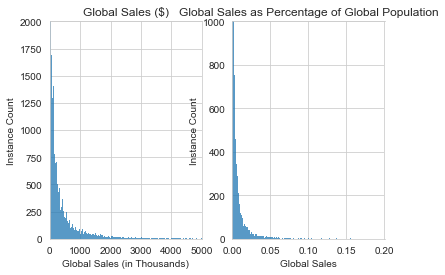

In [26]:
#Lets look at the distributions of global sales and global_sales_as_pct_of_pop, since one of those is likely to be our target variable
sns.set_style('whitegrid')

plt.subplot(1, 2, 1)
sns.histplot(videogames['Global_Sales'])
plt.title('Global Sales ($)')
plt.xlabel('Global Sales (in Thousands)')
plt.ylabel('Instance Count')
plt.xlim([0,5000])
plt.ylim([0,2000])

plt.subplot(1, 2, 2)
sns.histplot(videogames['global_sales_as_pct_of_pop'])
plt.title('Global Sales as Percentage of Global Population')
plt.xlabel('Global Sales')
plt.ylabel('Instance Count')
plt.xlim([0,0.2])
plt.ylim([0,1000])
#Here we see that the vast majority of video game titles on this list had sales between 0$ and $500K.
#Note that this dataset only includes video games that sold at least $100K copies.

#Since we have access to the year of each video game's release, that variable should already take care of the increasing
#population each year, and we shouldn't need to use the global sales as percentage of global population variable
#Global_Sales will be our main target

(0.0, 2000.0)

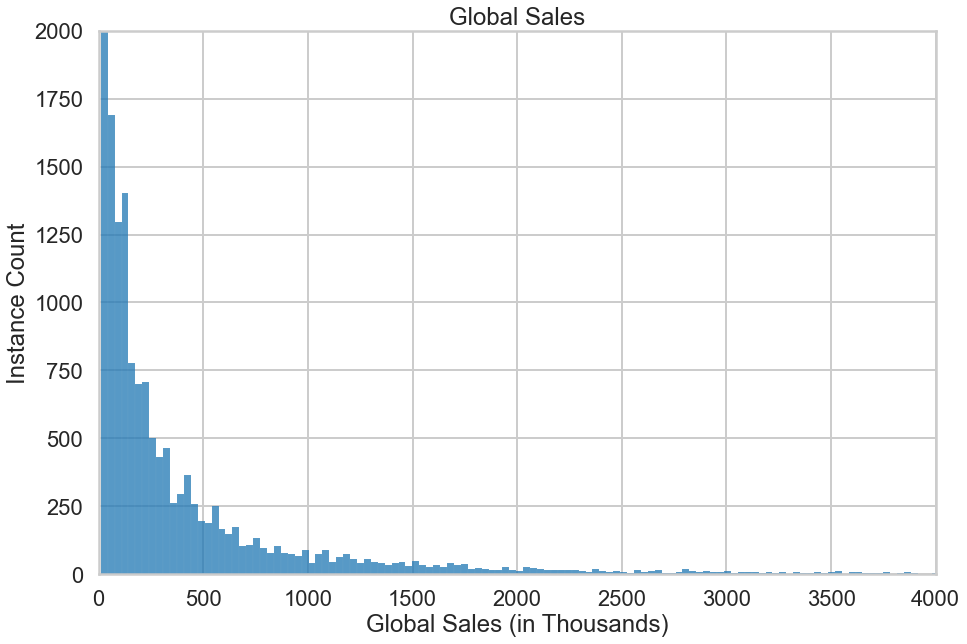

In [27]:
plt.figure(figsize = [15,10])
sns.set_context('poster')

ax = sns.histplot(videogames['Global_Sales'])
ax.set_title('Global Sales')
ax.set_xlabel('Global Sales (in Thousands)')
ax.set_ylabel('Instance Count')
ax.set_xlim([0,4000])
ax.set_ylim([0,2000])

Text(0, 0.5, 'Instance Count')

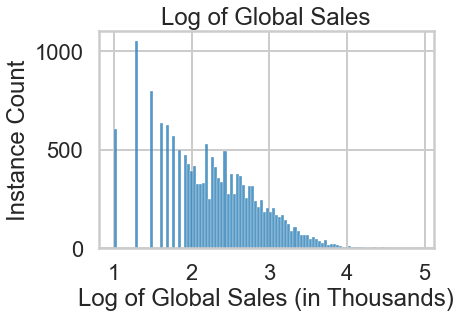

In [28]:
#Global_Sales has a very large mass around 0-0.5 and then a very long right tail.
#Let's see what the log transformation of Global Sales looks like.

sns.histplot(videogames['log_Global_Sales'],bins = 100)
plt.title('Log of Global Sales')
plt.xlabel('Log of Global Sales (in Thousands)')
plt.ylabel('Instance Count')

# The graph is very erratic at the lower ranges, which may make it difficult to make accurate predictions

In [30]:
# Let's look at correlations
videogames.corr()

# A lot of these are highly correlated simply because they are dependent on each other
# The things to note are:
# - Year is only very slightly negatively correlated with Global Sales, meaning there isn't a clear linear relationship between those two variables.
# - publisher_title_count is very slightly (0.121) positively correlated with Global_Sales
# - Most of our explanatory variables are actually categorical not numerical

Rank      Year  NA_Sales  EU_Sales  JP_Sales  \
Rank                        1.000000  0.178666 -0.400554 -0.379297 -0.268937   
Year                        0.178666  1.000000 -0.091513  0.005984 -0.169183   
NA_Sales                   -0.400554 -0.091513  1.000000  0.768119  0.450804   
EU_Sales                   -0.379297  0.005984  0.768119  1.000000  0.436052   
JP_Sales                   -0.268937 -0.169183  0.450804  0.436052  1.000000   
Other_Sales                -0.333030  0.040916  0.634838  0.726202  0.290377   
Global_Sales               -0.427193 -0.074793  0.941160  0.902954  0.612424   
publisher_title_count      -0.314956  0.013729  0.117791  0.122648  0.027259   
globalpop                   0.178654  0.999865 -0.092134  0.006384 -0.167950   
global_sales_as_pct_of_pop -0.417368 -0.112054  0.952334  0.866305  0.629392   
pub_avg_prior_sales        -0.376240 -0.217531  0.280321  0.222508  0.365289   
log_Global_Sales           -0.983440 -0.179553  0.499376  0.477925  0.339117   

                            Other_Sales  Global_Sales  publisher_title_count  \
Rank                          -0.333030     -0.427193              -0.314956   
Year                           0.040916     -0.074793               0.013729   
NA_Sales                       0.634838      0.941160               0.117791   
EU_Sales                       0.726202      0.902954               0.122648   
JP_Sales                       0.290377      0.612424               0.027259   
Other_Sales                    1.000000      0.748239               0.114342   
Global_Sales                   0.748239      1.000000               0.120929   
publisher_title_count          0.114342      0.120929               1.000000   
globalpop                      0.040479     -0.074799               0.012650   
global_sales_as_pct_of_pop     0.709572      0.992640               0.114722   
pub_avg_prior_sales            0.144591      0.309614               0.292640   
log_Global_Sales               0.414669      0.535021               0.309444   

                            globalpop  global_sales_as_pct_of_pop  \
Rank                         0.178654                   -0.417368   
Year                         0.999865                   -0.112054   
NA_Sales                    -0.092134                    0.952334   
EU_Sales                     0.006384                    0.866305   
JP_Sales                    -0.167950                    0.629392   
Other_Sales                  0.040479                    0.709572   
Global_Sales                -0.074799                    0.992640   
publisher_title_count        0.012650                    0.114722   
globalpop                    1.000000                   -0.112160   
global_sales_as_pct_of_pop  -0.112160                    1.000000   
pub_avg_prior_sales         -0.216531                    0.319541   
log_Global_Sales            -0.179462                    0.524065   

                            pub_avg_prior_sales  log_Global_Sales  
Rank                                  -0.376240         -0.983440  
Year                                  -0.217531         -0.179553  
NA_Sales                               0.280321          0.499376  
EU_Sales                               0.222508          0.477925  
JP_Sales                               0.365289          0.339117  
Other_Sales                            0.144591          0.414669  
Global_Sales                           0.309614          0.535021  
publisher_title_count                  0.292640          0.309444  
globalpop                             -0.216531         -0.179462  
global_sales_as_pct_of_pop             0.319541          0.524065  
pub_avg_prior_sales                    1.000000          0.397669  
log_Global_Sales                       0.397669          1.000000

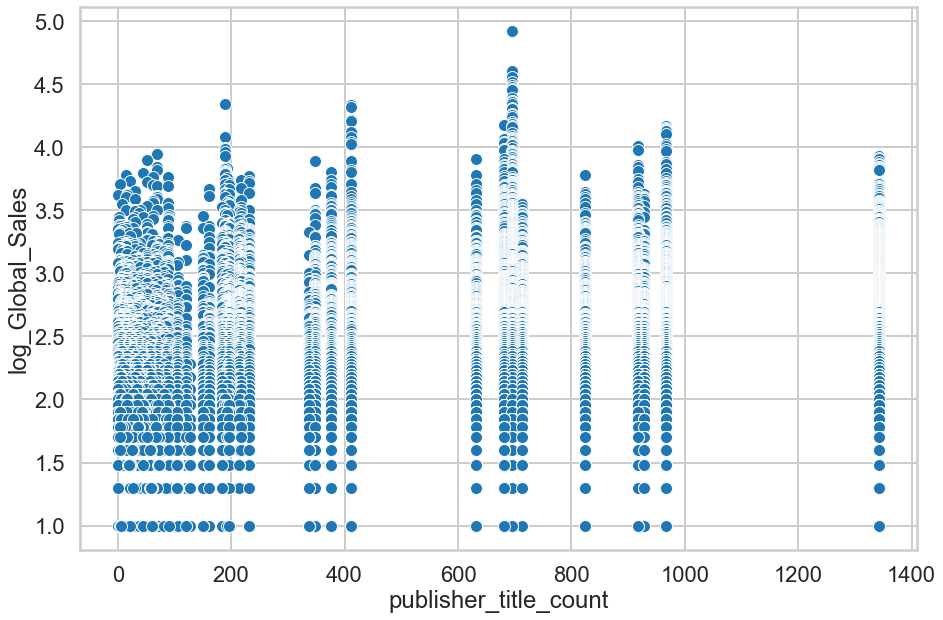

In [31]:
# Let's see what the relationship between publisher_title_count and log_Global_Sales looks like in a scatterplot

plt.figure(figsize = [15,10])
g = sns.scatterplot(x = 'publisher_title_count', y = 'log_Global_Sales', data = videogames)
plt.show()
# This variable is not of much use

(0.0, 40000.0)

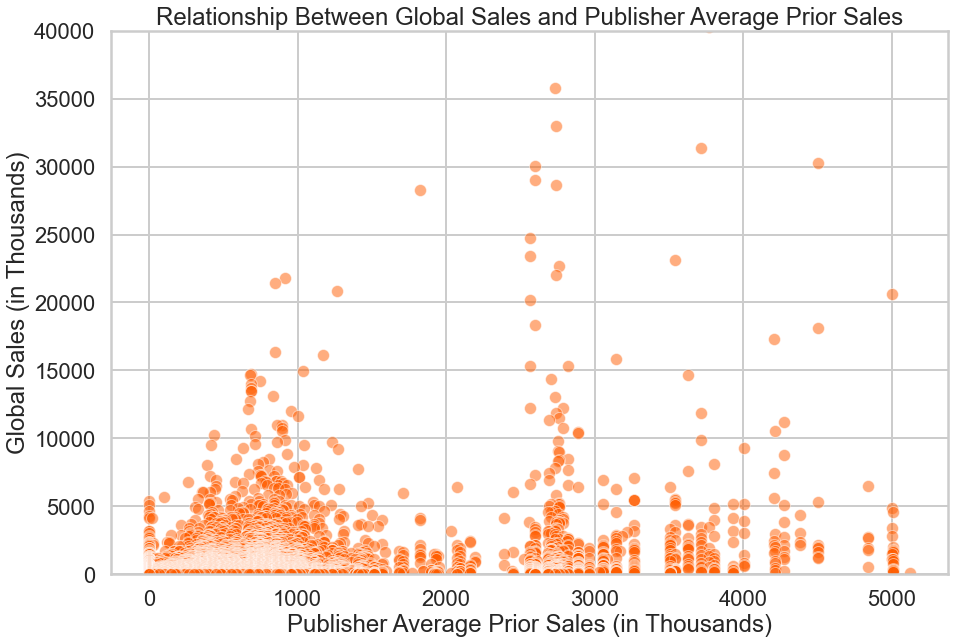

In [32]:
# Let's see what the relationship between pub_avg_prior_sales and log_Global_Sales looks like in a scatterplot

plt.figure(figsize = [15,10])
sns.set_context('poster')
ax = sns.scatterplot(x = 'pub_avg_prior_sales', y = 'Global_Sales', data = videogames, alpha = 0.5, color = '#ff5d00ff')
ax.set_xlabel('Publisher Average Prior Sales (in Thousands)')
ax.set_ylabel('Global Sales (in Thousands)')
ax.set_title('Relationship Between Global Sales and Publisher Average Prior Sales')
ax.set_ylim((0, 40000))
# There does seem to be a small positive relationship between these variables

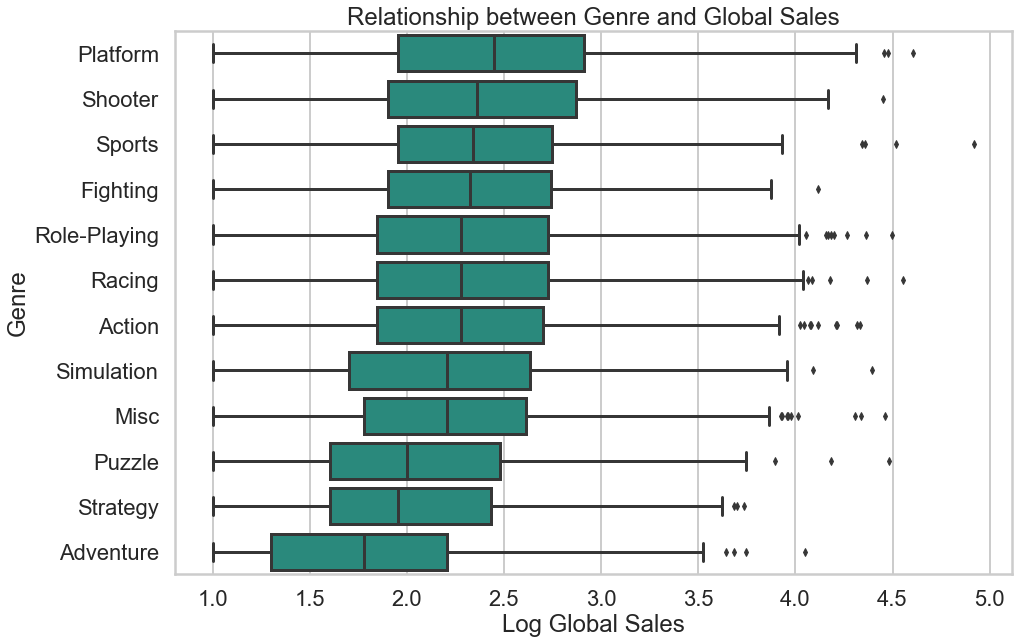

In [33]:
# Now let's explore the categorical variables in the dataset, and create a function to make it easier

def ordered_boxplot(dataframe, y, grouping, color = None):
    """Create boxplot of categorical variable on x-axis and log_Global_Sales on y-axis.
    Sort boxplot in decreasing order of median log_Global_Sales by category."""
    
    my_order = videogames.groupby(grouping)[y].median().sort_values(ascending = False).index

    plt.figure(figsize = [15,10])

    return sns.boxplot(x = y, y = grouping, orient = 'h', data = dataframe, order = my_order, color = color)


# Genre
ax = ordered_boxplot(videogames, 'log_Global_Sales', 'Genre', '#1a9988ff')
ax.set_title('Relationship between Genre and Global Sales')
ax.set_xlabel('Log Global Sales')
ax.set_ylabel('Genre')
#ax.set_yticklabels(ax.get_yticklabels(), rotation = 60)
plt.show()

# Platformers and Shooters appear to have very slightly higher medians but much higher 3rd quantiles
# Puzzle, adventure and strategy are significantly lower than the rest of the group

Text(0.5, 0, 'Log Global Sales')

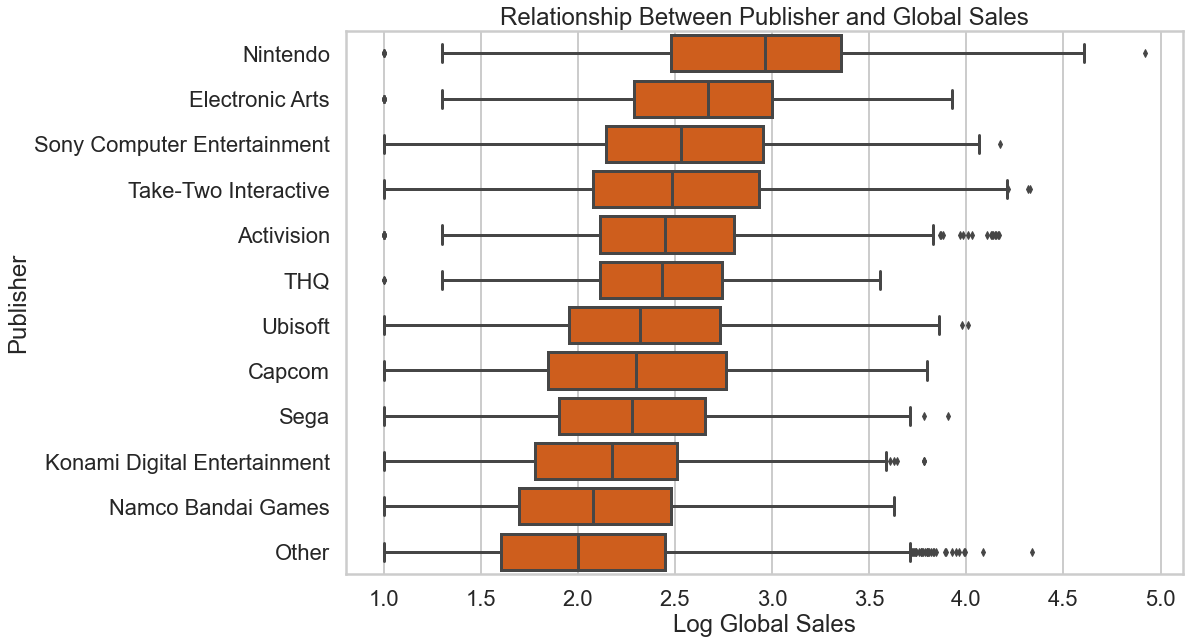

In [34]:
#Publisher_2
ax = ordered_boxplot(videogames, 'log_Global_Sales', 'Publisher_2','#eb5600ff')
ax.set_title('Relationship Between Publisher and Global Sales')
ax.set_ylabel('Publisher')
ax.set_xlabel('Log Global Sales')
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
# other appears to lag significantly behind the top 12
# Nintendo seems to be in a league of it's own

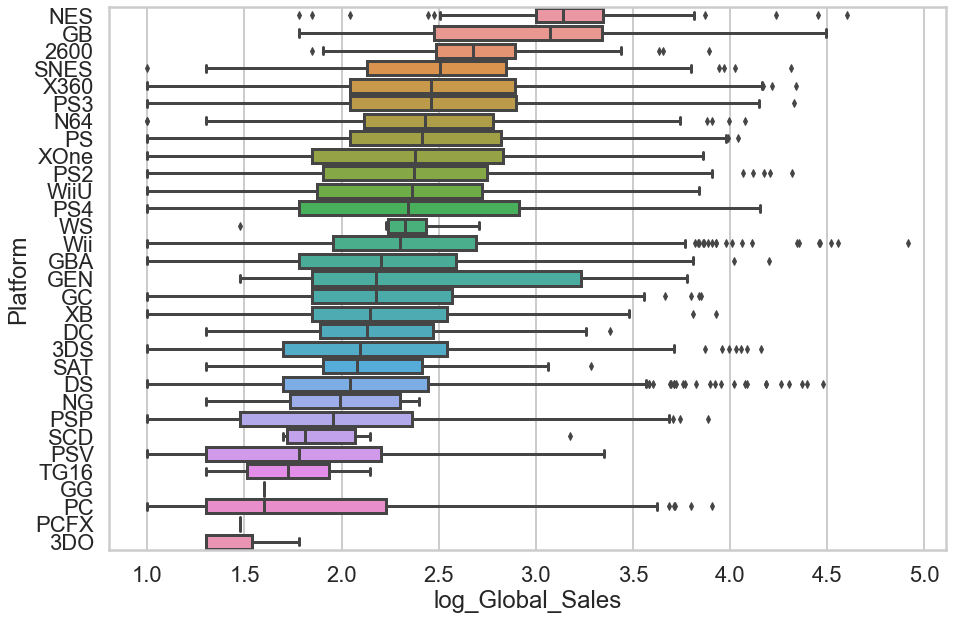

In [35]:
#Platform
ax = ordered_boxplot(videogames, 'log_Global_Sales', 'Platform')

Text(0, 0.5, 'Platform Category')

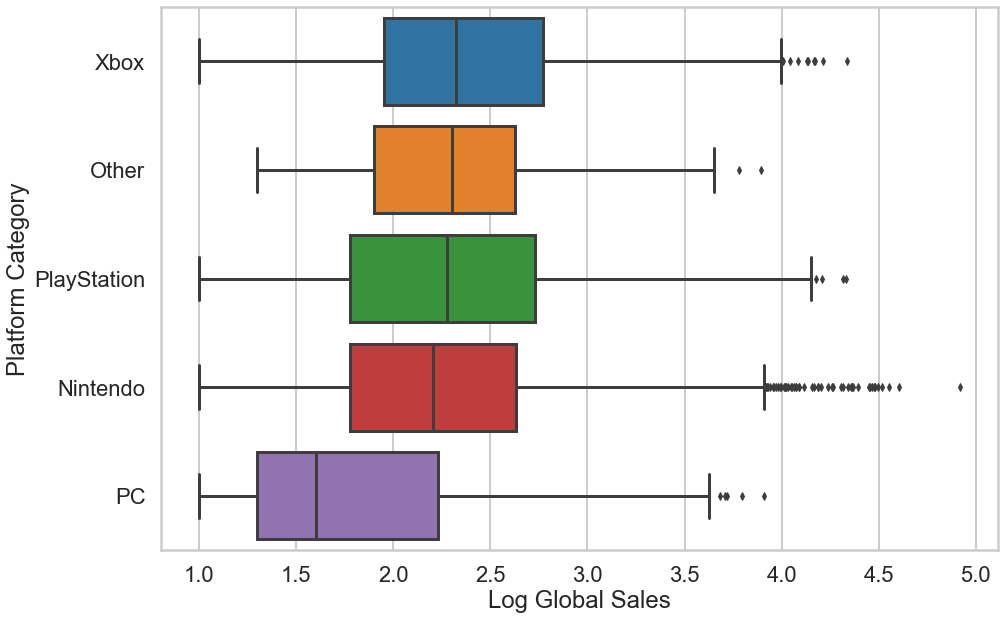

In [36]:
#Platformcat
ax = ordered_boxplot(videogames, 'log_Global_Sales', 'platformcat')
ax.set_xlabel('Log Global Sales')
ax.set_ylabel('Platform Category')
# PC lags far behind the other platforms on this list

Text(0, 0.5, 'Platform Type')

<Figure size 1080x720 with 0 Axes>

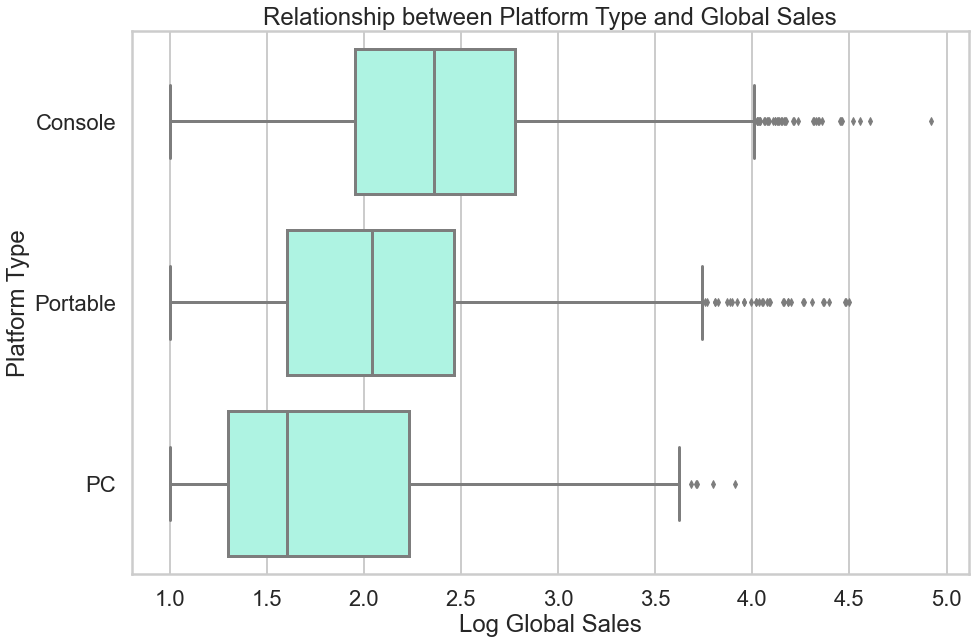

In [37]:
#Platformtype
plt.figure(figsize = (15,10))
ax = ordered_boxplot(videogames, 'log_Global_Sales', 'platformtype', '#a2ffe8ff')
ax.set_title('Relationship between Platform Type and Global Sales')
ax.set_xlabel('Log Global Sales')
ax.set_ylabel('Platform Type')
# This seems to be our most clear feature yet.
# Console sells more than portable which sells more than PC

Based on the exploration above, I am not confident that I will be able to put together an accurate model for
predicting the continous log_Global_Sales variable. I may have to change the aim of this project to a 
classification task (i.e. try to predict whether a title will have over 1 million in sales)

# Preprocessing

In [38]:
# Let's run a simple linear model to start
# First we need to binarize our categorical variables
encoder = OneHotEncoder(categories = 'auto', drop = None, sparse = False, )
videogames_categorical = videogames[['Genre', 'platformtype', 'Publisher_2']]
videogames_binarized = pd.DataFrame(data = encoder.fit_transform(videogames_categorical), columns = encoder.get_feature_names())
videogames_binarized.reset_index(drop = True, inplace = True)
videogames_binarized.head()

x0_Action  x0_Adventure  x0_Fighting  x0_Misc  x0_Platform  x0_Puzzle  \
0        0.0           0.0          0.0      0.0          0.0        0.0   
1        0.0           0.0          0.0      0.0          1.0        0.0   
2        0.0           0.0          0.0      0.0          0.0        0.0   
3        0.0           0.0          0.0      0.0          0.0        0.0   
4        0.0           0.0          0.0      0.0          0.0        0.0   

   x0_Racing  x0_Role-Playing  x0_Shooter  x0_Simulation  ...  \
0        0.0              0.0         0.0            0.0  ...   
1        0.0              0.0         0.0            0.0  ...   
2        1.0              0.0         0.0            0.0  ...   
3        0.0              0.0         0.0            0.0  ...   
4        0.0              1.0         0.0            0.0  ...   

   x2_Electronic Arts  x2_Konami Digital Entertainment  x2_Namco Bandai Games  \
0                 0.0                              0.0                    0.0   
1                 0.0                              0.0                    0.0   
2                 0.0                              0.0                    0.0   
3                 0.0                              0.0                    0.0   
4                 0.0                              0.0                    0.0   

   x2_Nintendo  x2_Other  x2_Sega  x2_Sony Computer Entertainment  x2_THQ  \
0          1.0       0.0      0.0                             0.0     0.0   
1          1.0       0.0      0.0                             0.0     0.0   
2          1.0       0.0      0.0                             0.0     0.0   
3          1.0       0.0      0.0                             0.0     0.0   
4          1.0       0.0      0.0                             0.0     0.0   

   x2_Take-Two Interactive  x2_Ubisoft  
0                      0.0         0.0  
1                      0.0         0.0  
2                      0.0         0.0  
3                      0.0         0.0  
4                      0.0         0.0  

[5 rows x 27 columns]

In [39]:
# Create predictor variables
X = pd.concat([videogames.loc[:,['Year','pub_avg_prior_sales']], videogames_binarized], axis = 1)

# Create target variable
y = videogames[['log_Global_Sales']]

# Create train/test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, train_size = .75, random_state = 123)
X_train_reg.shape, X_test_reg.shape, y_train_reg.shape, y_test_reg.shape

((12255, 29), (4085, 29), (12255, 1), (4085, 1))

## Linear Regression Testing

In [40]:
# run model, evaluate R_squared, and look at coefficients
linear_model_1 = linear_model.LinearRegression()
linear_model_1.fit(X_train_reg, y_train_reg)
y_pred = linear_model_1.predict(X_train_reg)
linear_model_1.score(X_train_reg, y_train_reg), mean_absolute_error(y_train_reg, y_pred), linear_model_1.coef_

# We have a very low R_squared value of 0.2948, and it doesn't appear that the coefficients are even helpful

(0.2948184790557301,
 0.42656367245306975,
 array([[-0.00476957,  0.00039182,  0.04986162, -0.23594805,  0.08214243,
         -0.00727487,  0.08261675, -0.08821616, -0.00983428,  0.12481478,
          0.0916178 ,  0.03854636, -0.02110076, -0.10722562,  0.22755806,
         -0.24743538,  0.01987731,  0.09373021, -0.1031493 ,  0.25065864,
         -0.05443567, -0.12291061, -0.32210881, -0.13853261,  0.02669497,
          0.05695274,  0.12335177,  0.05599765,  0.133751  ]]))

In [41]:
y_train_reg = np.ravel(y_train_reg)
y_test_reg = np.ravel(y_test_reg)

X_train_reg.shape, X_test_reg.shape, y_train_reg.shape, y_test_reg.shape

((12255, 29), (4085, 29), (12255,), (4085,))

In [42]:
# run this to reload the two models, the dataframe and the binarized categorical variables
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_classifier_1.pkl'

with open(filename, 'rb') as file:
    forest_classifier_1 = pickle.load(file)
    
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_model_1.pkl'

with open(filename, 'rb') as file:
    forest_model_1 = pickle.load(file)

filename = 'C:/Users/atyou/CapstoneTwo/Data/videogames_clean.pkl'

with open(filename, 'rb') as file:
    videogames = pickle.load(file)
    
filename = 'C:/Users/atyou/CapstoneTwo/Data/videogames_binarized.pkl'

with open(filename, 'rb') as file:
    videogames_binarized = pickle.load(file)

## Random Forest Regressor Testing

In [43]:
# Now let's run a random forest regressor to see if we can get a better result

# create model
forest_model_1 = ensemble.RandomForestRegressor(
    n_estimators = 100,
    criterion = 'mae',
    max_depth = None,
    min_samples_split = 2,
    min_samples_leaf = 2,
    random_state = 123,
    n_jobs = -1)

#fit model
forest_model_1.fit(X_train_reg, y_train_reg)

KeyboardInterrupt: 

In [ ]:
#evaluate model
y_pred = forest_model_1.predict(X_train_reg)
forest_model_1.score(X_train_reg, y_train_reg), mean_absolute_error(y_train_reg, y_pred)

# This massively improved the r_squared to 0.63.
# We may be able to improve on this through a grid_search of hyperparameter values

In [ ]:
# Let's take a look at the feature importances
list(zip(X_train_reg.columns, forest_model_1.feature_importances_))

# It appears that the two most important features are 'Year' and 'pub_avg_prior_sales'

In [ ]:
# Let's see how this performs on the test set, since I have a hunch that it may be overfitting the training data

test_y_pred = forest_model_1.predict(X_test_reg)
mean_absolute_error(y_test_reg, test_y_pred)

# There is a large gap in the performance between the training and test set (0.91 compared to 0.67)
# This may be addressed with hyperparameter tuning and cross-validation in the future

In [ ]:
# for the last model that we'll test, let's run a random forest classifier, to see if we can predict 
# whether a title will have sales above a certain level. For now we'll use 1,000,000 (1,000 thousand)

y_1000 = np.ravel(np.array([int(x > 1000) for x in videogames['Global_Sales']]))
X_train_1000, X_test_1000, y_train_1000, y_test_1000 = train_test_split(X, y_1000, train_size = 0.75, random_state = 123)
X_train_1000.shape, X_test_1000.shape, y_train_1000.shape, y_test_1000.shape


## Random Forest Classifier Testing

In [ ]:
# create model object

forest_classifier_1 = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    max_depth = None,
    min_samples_split = 2,
    min_samples_leaf = 2,
    random_state = 123,
    n_jobs = -1)

#fit model
forest_classifier_1.fit(X_train_1000, y_train_1000)

In [ ]:
#evaluate model
y_pred = forest_classifier_1.predict(X_train_1000)
forest_classifier_1.score(X_train_1000, y_train_1000)

In [ ]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_train_1000, y_pred).ravel()

print('True Negatives: ' + str(tn)), print('False Positives :' + str(fp)), print('False Negative :' + str(fn)), print('True Positives :' + str(tp))





In [ ]:
classification_report(y_train_1000, y_pred, output_dict = True)

In [ ]:
# feature importances
list(zip(X_train_1000.columns, forest_classifier_1.feature_importances_))

# Similar to the random forest regressor, 'Year' and 'pub_avg_prior_sales' are the two most important variables by far

In [ ]:
# Save random forest regressor
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_model_1.pkl'

with open(filename, 'wb') as file:
    pickle.dump(forest_model_1, file)


# Save random forest classifier
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_classifier_1.pkl'

with open(filename, 'wb') as file:
    pickle.dump(forest_classifier_1, file)
    
# Save videogames dataframe
filename = 'C:/Users/atyou/CapstoneTwo/Data/videogames_clean.pkl'

with open(filename, 'wb') as file:
    pickle.dump(videogames, file)

# Save dummy variables
filename = 'C:/Users/atyou/CapstoneTwo/Data/videogames_binarized.pkl'

with open(filename, 'wb') as file:
    pickle.dump(videogames_binarized, file)

PRELIMINARY RESULTS

We ran a simple linear regression, a random forest regressor and a random forest classifier on the videogames dataset along with some features that I created. 

The simple linear regression was not accurate at all (R-squared ~ 0.3).

The random forest regressor was fairly accurate (R-squared ~ 0.63) but may be prone to overfitting.

The random forest classifier was accurate (Accuracy ~ 0.91) but did not do well at predicting the minority class, which is the important one. The next step is to see if we can improve this performance through hyper-parameter tuning, different classificaiton threshholds, or different class separations (i.e. predict greater than $500000 instead of greater than $1000000)

In [ ]:
videogames.head()

In [ ]:
# First let's try setting our classes at different levels
X = pd.concat([videogames.loc[:,['Year','pub_avg_prior_sales']], videogames_binarized], axis = 1)

def class_cutoff_test(target_column, X, cutoffs, model):
    """Evaluate a model at different class cutoffs"""
    
    forest_classifier = ensemble.RandomForestClassifier(
        n_estimators = 100,
        criterion = 'gini',
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 2,
        random_state = 123)
    
    for cutoff in cutoffs:
        y = np.ravel(np.array([int(x > cutoff) for x in target_column])) 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
        forest_classifier.fit(X_train, y_train)
        y_pred = forest_classifier.predict(X_test)
        report = classification_report(y_test, y_pred,output_dict = True)
        
        print('{} Cutoff'.format(cutoff))
        print(report['1'])
    

class_cutoff_test(videogames['Global_Sales'], X, [1000, 750, 500, 250], forest_classifier_1)
    
# Performance sharply increases for the lower cutoffs, due to having higher support
# The $250,000 cutoff is the best performing, but offers the least relevant information
# Let's move forward and try parameter tuning on the 500000 cutoff


In [ ]:

# create train/test split
y_500 = np.ravel(np.array([int(x > 500) for x in videogames['Global_Sales']]))
X_train_500, X_test_500, y_train_500, y_test_500 = train_test_split(X, y_500, test_size = 0.25, random_state = 123)

# define parameter grid
params = {'criterion': ['gini', 'entropy'],
         'max_depth': [None, 2, 5, 10],
         'min_samples_split': [2, 5, 10, 50, 75, 100],
         'min_samples_leaf': [1, 2, 10, 50],
         'class_weight': [None, 'balanced', 'balanced_subsample'],
         'n_jobs': [-1],
         'random_state': [123]}

# instantiate model
model = ensemble.RandomForestClassifier()

# create f1 scorer
f1_scorer = make_scorer(f1_score)

# instantiate grid object
forestgrid = GridSearchCV(model, params, scoring = f1_scorer, n_jobs = -1, cv = 5)


#fit the grid search
#forestgrid.fit(X_train_500, y_train_500)

In [ ]:
# Load final random forest classifier instead of rerunning grid search every time
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_classifier_final.pkl'

with open(filename, 'rb') as file:
    forest_classifier_final = pickle.load(file)

In [ ]:
#gridresults = pd.DataFrame(forestgrid.cv_results_)

In [ ]:
#gridresults.sort_values('rank_test_score')

In [ ]:
# parameters for best model
#forest_classifier_final = forestgrid.best_estimator_
forest_classifier_final.get_params()

In [ ]:
# evaluate on test set
y_test_pred = forest_classifier_final.predict(X_test_500)
classification_report(y_test_500, y_test_pred, output_dict = True)

In [ ]:
# Save final random forest classifier
filename = 'C:/Users/atyou/CapstoneTwo/Models/forest_classifier_final.pkl'

with open(filename, 'wb') as file:
    pickle.dump(forest_classifier_final, file)

In [ ]:
# The random forest classifier was a slight success
# For fun, let's try an adaboost model and see what results we get

# define parameter grid
params = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# instantiate model
model = ensemble.AdaBoostClassifier()

# create f1 scorer
f1_scorer = make_scorer(f1_score)

# instantiate grid object
adagrid = GridSearchCV(model, params, scoring = f1_scorer, n_jobs = -1, cv = 5)


#fit the grid search
adagrid.fit(X_train_500, y_train_500)

In [ ]:
gridresults = pd.DataFrame(adagrid.cv_results_)

In [ ]:
gridresults.sort_values('rank_test_score')

In [ ]:
# Let's train an SVC and see if stacking it on top of the random forest classifier will improve performance
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

svc = LinearSVC()
X_svc = MinMaxScaler().fit_transform(X)
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y_500, train_size = 0.75, random_state = 123)

params = {'penalty': ['l1', 'l2'],
         'loss': ['hinge', 'squared_hinge'],
         'C': [0.1, 0.2, 0.5, 0.75, 1.0],
         'tol': [10**-4, 10**-3, 10**-2, 10**-1, 10**0],
         'class_weight': [None, 'balanced'],
         'random_state': [123]}

svcgrid = GridSearchCV(svc, params, scoring = f1_scorer, n_jobs = -1, cv = 5)



In [ ]:
#svcgrid.fit(X_train_svc, y_train_svc)

In [ ]:
# Load final svc instead of rerunning grid search every time
filename = 'C:/Users/atyou/CapstoneTwo/Models/svc_classifier_final.pkl'

with open(filename, 'rb') as file:
    svc_classifier_final = pickle.load(file)

In [ ]:
#gridresults = pd.DataFrame(svcgrid.cv_results_)
#gridresults.sort_values('rank_test_score')

In [ ]:
#svc_classifier_final = svcgrid.best_estimator_
svc_classifier_final.get_params()

In [ ]:
y_test_pred = svc_classifier_final.predict(X_test_svc)
classification_report(y_test_svc, y_test_pred, output_dict = True)

In [ ]:
# Save final SVC
filename = 'C:/Users/atyou/CapstoneTwo/Models/svc_classifier_final.pkl'

with open(filename, 'wb') as file:
    pickle.dump(svc_classifier_final, file)

## Stacked Model Testing

As a last ditch effort let's test a stacked model combining the final random forest regressor as well as the final SVC.

In [ ]:
# import pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

# define estimators
estimators = [('rf', forest_classifier_final), ('svc', make_pipeline(MinMaxScaler(), svc_classifier_final))]

clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())

In [ ]:
clf.fit(X_train_500, y_train_500)

In [ ]:
y_test_pred = clf.predict(X_test_500)
classification_report(y_test_500, y_test_pred, output_dict = True)

Interestingly the stacked model seems to have greatly improved precision, at the cost of greatly reduced recall. The random forest classifier still seems to be the best overall model.

# Final Model Metrics

In [ ]:
# Parameters
forest_classifier_final.get_params()

In [ ]:
# Perforamnce on Training Set

y_train_pred = forest_classifier_final.predict(X_train_500)
classification_report(y_train_500, y_train_pred, output_dict = True)

In [ ]:
# Performance on Test Set

y_test_pred = forest_classifier_final.predict(X_test_500)
classification_report(y_test_500, y_test_pred, output_dict = True)

In [ ]:
# Feature Importance
feature_importances = pd.DataFrame({'Feature': X_train_500.columns, 'Importance': forest_classifier_final.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending = False)
feature_importances

In [ ]:
plt.figure(figsize = (15, 10))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = feature_importances, color = '#3bbbe1')
ax.set_title('Feature Importance for Final Random Forest Classifier')
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 17)